## 2. Model Training

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


#### 2.1 Data Preparation for model

In [27]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dir = "./dataset/VegetableImages/train/"
train_ds = image_dataset_from_directory(train_dir,
                                      subset="training", 
                                      validation_split=0.1,
                                      seed=123, 
                                      image_size=(224, 224),
                                      batch_size= 5000)


test_ds = "./dataset/VegetableImages/test/"
test_ds = image_dataset_from_directory(
                                    test_ds,
                                    labels='inferred',
                                    label_mode='int',
                                    class_names=None,
                                    color_mode='rgb',
                                    batch_size=1000,
                                    image_size=(224, 224),
                                    shuffle=True,
                                    seed=None,
                                    validation_split=None,
                                    subset=None,
                                    interpolation='bilinear',
                                    follow_links=False,
                                    crop_to_aspect_ratio=False
                                )

Found 5000 files belonging to 5 classes.
Using 4500 files for training.
Found 994 files belonging to 5 classes.


In [28]:
x_train = None
y_train = None
for image, label in train_ds.as_numpy_iterator():
    x_train = image
    y_train = label
    
x_test = None
y_test = None
for image, label in test_ds.as_numpy_iterator():
    x_test = image
    y_test = label
    
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4500, 224, 224, 3) - y_train shape: (4500,)
x_test shape: (994, 224, 224, 3) - y_test shape: (994,)


In [29]:
class_names = train_ds.class_names
print(class_names)

['Bean', 'Papaya', 'Potato', 'Radish', 'Tomato']


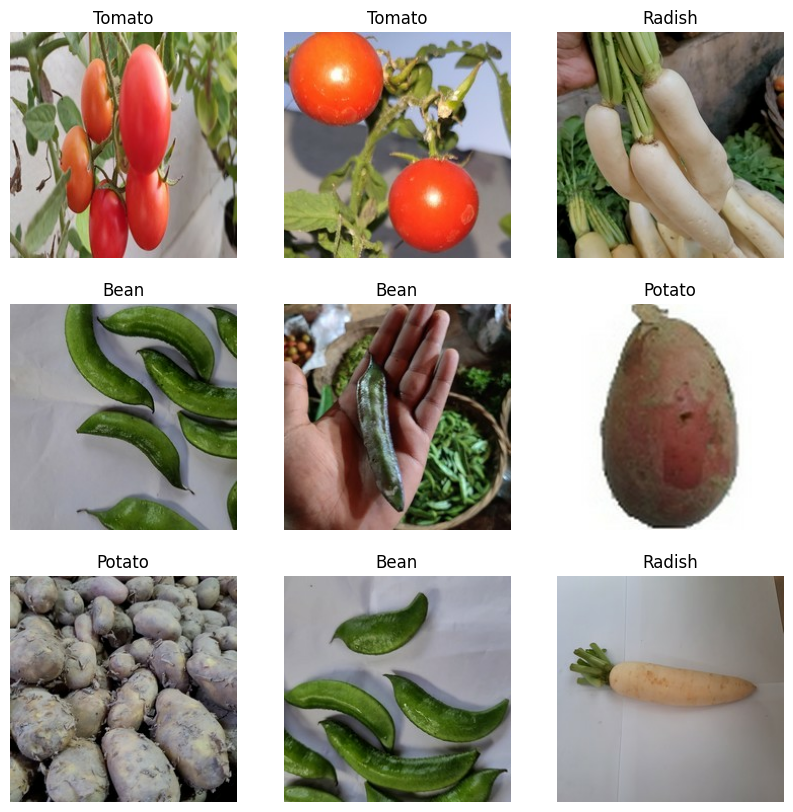

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### 2.2 Hyperparameter for model

In [31]:
learning_rate = 0.001
weight_decay = 0.0005
batch_size = 32
num_epochs = 200
image_size = 72  
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

#### 2.3 Defining model architecute

In [33]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [34]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [35]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [36]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [37]:
num_classes = 5
input_shape = (224, 224, 3)

In [38]:
vit_classifier = create_vit_classifier()

In [39]:
def run_experiment(model):
    optimizer =  tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy= model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [40]:
# vit_classifier = keras.models.load_model('./Model/pesudo-labeled-model-v3/')

In [41]:
with tf.device('/GPU:0'):
    history = run_experiment(vit_classifier)

Epoch 1/200
127/127 [==============================] - 23s 105ms/step - loss: 1.8201 - accuracy: 0.6780 - val_loss: 0.3071 - val_accuracy: 0.9044
Epoch 2/200
127/127 [==============================] - 12s 92ms/step - loss: 0.4631 - accuracy: 0.8568 - val_loss: 0.2223 - val_accuracy: 0.9267
Epoch 3/200
127/127 [==============================] - 12s 91ms/step - loss: 0.2158 - accuracy: 0.9309 - val_loss: 0.1043 - val_accuracy: 0.9667
Epoch 4/200
127/127 [==============================] - 9s 71ms/step - loss: 0.1906 - accuracy: 0.9459 - val_loss: 0.1139 - val_accuracy: 0.9644
Epoch 5/200
127/127 [==============================] - 11s 90ms/step - loss: 0.1360 - accuracy: 0.9583 - val_loss: 0.0813 - val_accuracy: 0.9689
Epoch 6/200
127/127 [==============================] - 12s 91ms/step - loss: 0.1628 - accuracy: 0.9494 - val_loss: 0.0863 - val_accuracy: 0.9867
Epoch 7/200
127/127 [==============================] - 9s 71ms/step - loss: 0.1073 - accuracy: 0.9637 - val_loss: 0.0985 - val_acc

#### 2.4 Training and Validation graph

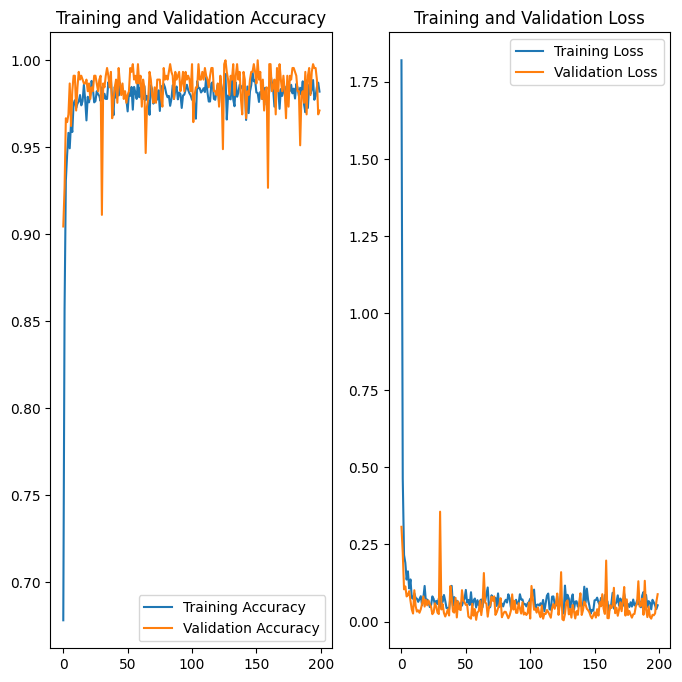

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(200)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 2.5 Saving the model 

In [43]:
vit_classifier.save("./model/veggies-model-v1/")

2023-06-03 18:41:38.584708: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./model/veggies-model-v1/assets


INFO:tensorflow:Assets written to: ./model/veggies-model-v1/assets


#### 2.6 Testing the model 

In [44]:
# uncomment when loading for the first time to load the model
# vit_classifier = keras.models.load_model('./Model/pectera-labeled-model-v7/')

In [1]:
prediction_classes = np.argmax(vit_classifier.predict(x_test), axis = -1)

NameError: name 'np' is not defined

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.99      0.99       200
           2       1.00      0.98      0.99       200
           3       0.98      1.00      0.99       194
           4       1.00      1.00      1.00       200

    accuracy                           0.99       994
   macro avg       0.99      0.99      0.99       994
weighted avg       0.99      0.99      0.99       994



In [57]:
a = vit_classifier.predict(x_test)

In [58]:
type(a)

numpy.ndarray

In [59]:
np.argmax(a, axis = -1)

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])